# Lab book

## 2017-07-10

A trial at using a python notebook as a labbook, recognising that a lab book, with dates and a time line, and the display of certain results is quite distinct from a "working" python notebook which might be used for analysis of results.

To summarise progress so far:

I have reproduced Basab's basal ganglia model using SpineML, which she has implemented for SpiNNaker. To achieve this, I've had to find out about the working of SpiNNaker models, and have led myself down a couple of blind alleys, but have learned the following:

SpiNNaker implements an Izhikevich model which can be very closely modelled on SpineML.

SpiNNaker implements a conductance based synapse model which adds a conductance with each spike. The amount of conductance added per spike depends on the source of the spike as well as the destination. Each spike is therefore what in the SpineML world we call an "impulse".

Although there is no mathematical limit applied to the size of the excitatory or inhibitory conductance at the receiving neuron, SpiNNaker has a built-in limit due to the impulse being encoded in a fixed-width representation.

To reproduce this limit, I have coded up SpiNNaker-like synapse models GABASpiNN, GABASpiNNgbar and AMPASpiNN, AMPASpiNNgbar. The gbar versions of these synapse models are for use in event based models - an incoming spike causes an increase in the conductance, $g$ of $\bar{g}$. The non-gbar versions are for using impulse based models, where the $\bar{g}$ is incorporated into the impulse. Both versions of each synapse model have a paramter g_limit, which would usually be set to 256, 512 or 1024 to match the kind of maximums which the run-time defined, fixed-width scaling applies. GABASpiNN and AMPASpiNN are functionally the same; I could have created just "SpiNNSyn" and "SpiNNSyngbar" components.

In the notebook GPR-BSB-1CH, I've set up code to run some of the experiments specified in the SpineML models bgbsb1 (which is event based) and bgbsb1_impt (impulse "pass-through"). The input is set up as per Basab's experiments; with  700 ms to start with no input, 5200 ms of 3Hz Poisson spiking and a final 100 ms of no input to make 6 s total.

As in Basab's experiments, I have set the exact connectivity to be selected with a time-generated seed at run-time and the Poisson spike trains also have a different, time-generated seed on each run.

I have written R scripts to do some bootstrap analyses on the spike rates generated to determine if the models are statistically different or not.

What I have found is that the two different versions of the 1 channel SpineML model, and the SpiNNaker version of the 1 channel SpineML model all generate statistically significantly different population firing rates.

### 13:00

Just received updated information on the g_limits that SpiNNaker applies to the model. I've applied these in the bgbsb1_impt model. In the bgbsb1 and bgbsb3 models, I've set all the g_limits to 256 uS. I'm going to re-run my "run the model 30 times" scheme on bgbsb1_impt now. See commit d2d544b for results.

## 2017-07-11

I found a problem in bgbsb1_impt - the scheme I was using in the impulse passthrough components, where I switched between regimes, was causing impulses to be lost in some circumstances. I changed the components (commit aa51aa3) which has sorted this problem out. I was hopeful that this would bring my bgbsb1 and bgbsb1_impt models into line so that they would produce statistically equivalent results, but it still hasn't. Here's the output of bgbsb1_spineml_compare.r:

```
[1] "***********  Means  *************"
[1] "Impulse based model, D1 mean: 2915.500000 spikes with stderr 72.054042"
[1] "Impulse based model, STN mean: 1083.500000 spikes with stderr 1.185263"
[1] "Impulse based model, GPe mean: 8345.833333 spikes with stderr 3.128809"
[1] "Impulse based model, SNr mean: 3562.733333 spikes with stderr 4.007477"
[1] "Event based model, D1 mean: 3319.400000 spikes with stderr 88.865515"
[1] "Event based model, STN mean: 1082.433333 spikes with stderr 1.238305"
[1] "Event based model, GPe mean: 8329.433333 spikes with stderr 3.700687"
[1] "***********  Difference/Stderr  *************"
[1] "For D1 evbased/impulsebased, difference is 403.900000, standard error estimate: 107.462073"
[1] "For STN evbased/impulsebased, difference is -1.066667, standard error estimate: 1.706968"
[1] "For GPe evbased/impulsebased, difference is -16.400000, standard error estimate: 5.176953"
[1] "For SNr evbased/impulsebased, difference is -22.966667, standard error estimate: 5.889134"
[1] "***********  Studentized t-test  *************"
[1] "numbeyond: 4 out of 10000"
[1] "Achieved significance level for Evbased vs Impulse based D1 population = 0.000400"
[1] "numbeyond: 2595 out of 10000"
[1] "Achieved significance level for Evbased vs Impulse based STN population = 0.259500"
[1] "numbeyond: 15 out of 10000"
[1] "Achieved significance level for Evbased vs Impulse based GPe population = 0.001500"
[1] "numbeyond: 4 out of 10000"
[1] "Achieved significance level for Evbased vs Impulse based SNr population = 0.000400"

```
Nonetheless, STN population spike rates are equivalent. The difference in the D1 rates is most worrying.

To further investigate, I've created cut-down models with just D1 and an FSI population (though I made the FSI neurons the same as the D1 neurons and increased the synapse $\bar{g}$ so these neurons would spike more).

I fixed the connectivity in these cut-down models and just allowed the spike input to have a variable seed. Here's output from bgbsb1_evimp_compare.r:

```
> source('bgbsb1_evimp_compare.r')
[1] "***********  Means/medians  *************"
[1] "Impulse based model, D1 mean: 2749.866667 spikes with stderr 57.519956"
[1] "Impulse based model, FSI mean: 660.933333 spikes with stderr 9.991471"
[1] "Event based model, D1 mean: 2820.333333 spikes with stderr 125.810838"
[1] "Event based model, FSI mean: 666.000000 spikes with stderr 16.439363"
[1] "***********  Difference/Stderr  *************"
[1] "For D1 evbased/impulsebased, difference is 70.466667, standard error estimate: 152.492858"
[1] "For FSI evbased/impulsebased, difference is 5.066667, standard error estimate: 20.928344"
[1] "***********  Studentized t-test  *************"
[1] "numbeyond: 3011 out of 10000"
[1] "Achieved significance level for Evbased vs Impulse based D1 population = 0.301100"
[1] "numbeyond: 3934 out of 10000"
[1] "Achieved significance level for Evbased vs Impulse based FSI population = 0.393400"
```

These ARE statistically equivalent!

I've now fixed the connectivity in the full bgbsb1 and bgbsb1_impt models, adding the suffix _fixcon to their model folders and I'm running the models 15 times with a view to comparing them again. Result: still resolutely different. So I need to build up the models until they stop being equivalent, starting from the very cut down models.

Actually, ARE they really so different? Looking at the results of a run of the fixed connection models with the same spike train inputs, we see slightly, but not dramatically different spike rates between the models:



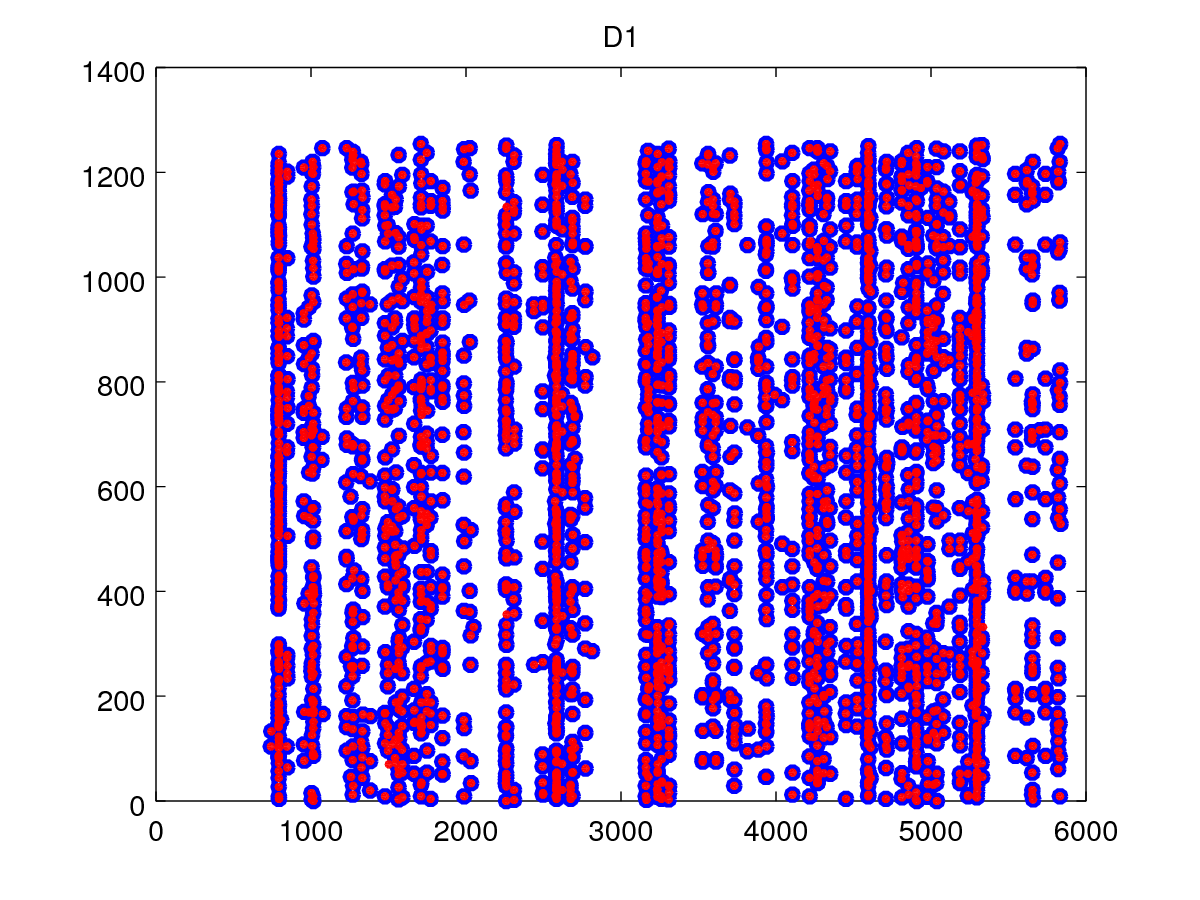

In [7]:
# D1 spikes almost line up perfectly as they are driven by the Poisson spiking. In this graph, 
# the blue circles are spikes from the event based model red dots are from the impulse based model.
from IPython.display import Image
Image(filename='fixedmodelcompare/d1.png')

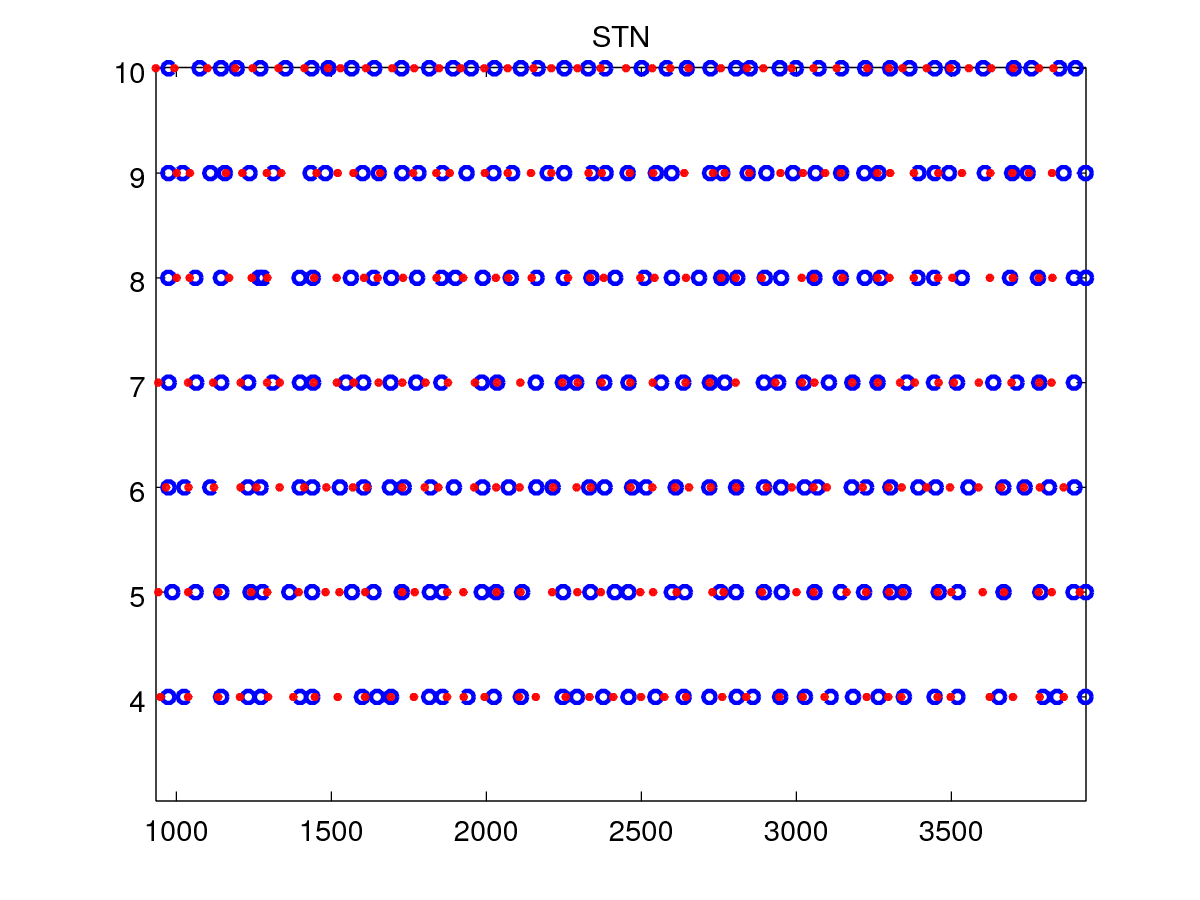

In [6]:
# STN spikes are more chaotic; less driven by the input from the 2 Poisson spike trains that they see.
from IPython.display import Image
Image(filename='fixedmodelcompare/stn.png')

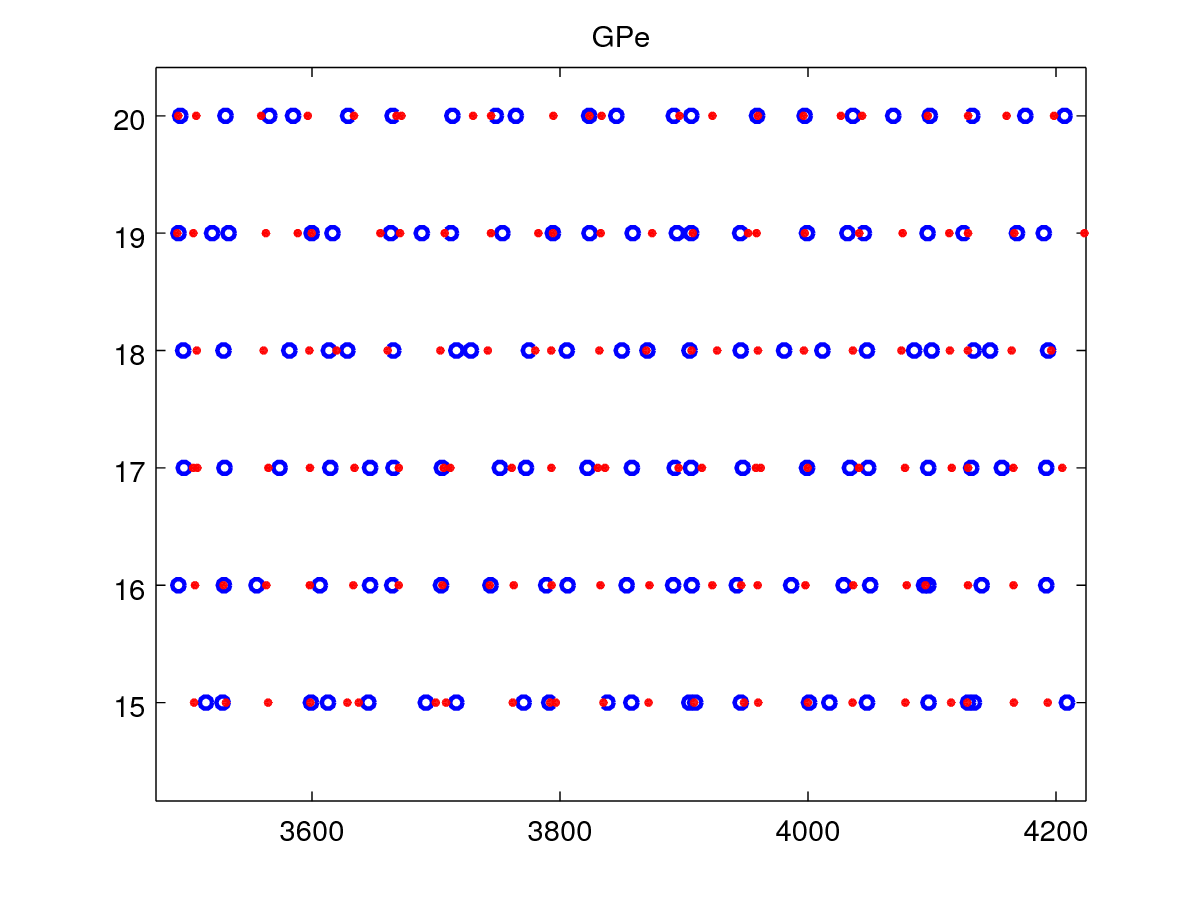

In [4]:
from IPython.display import Image
Image(filename='fixedmodelcompare/gpe.png')

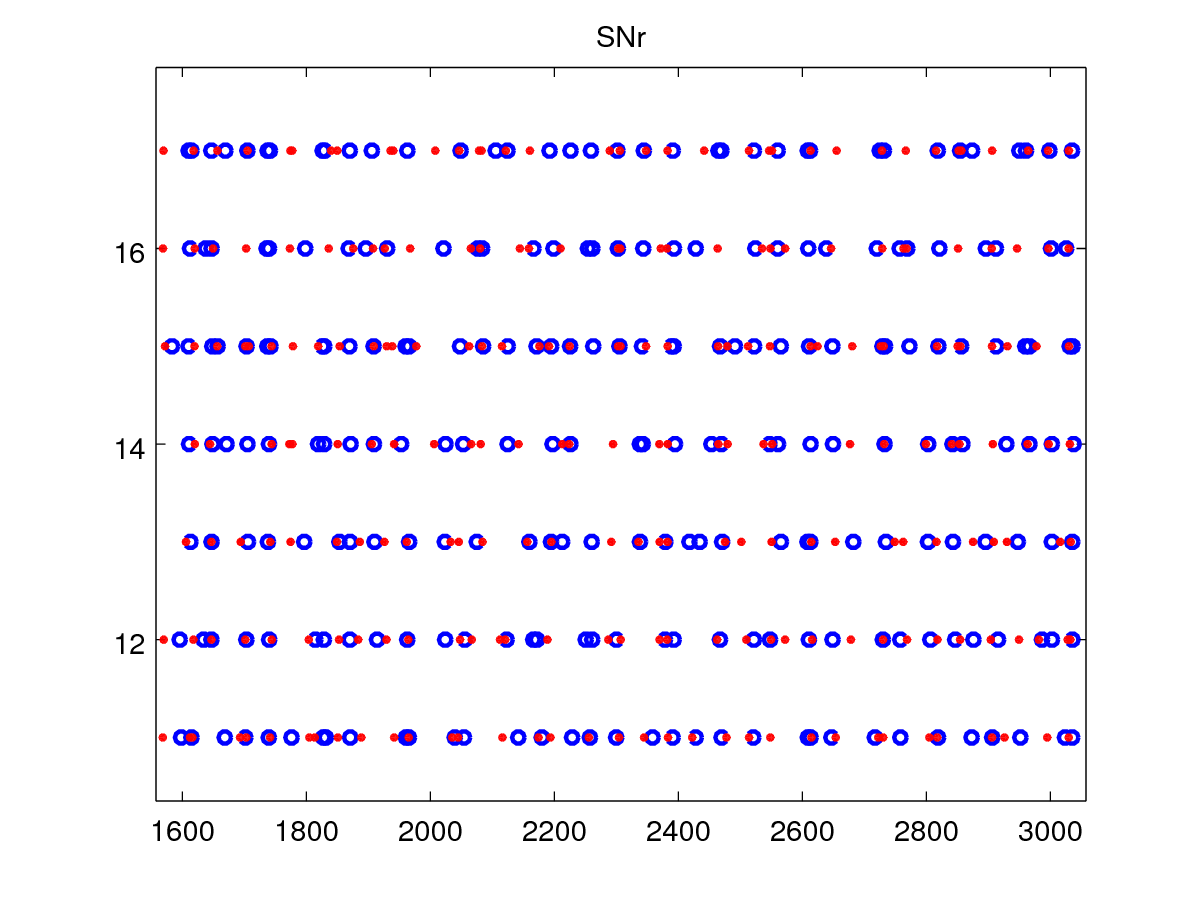

In [5]:
from IPython.display import Image
Image(filename='fixedmodelcompare/snr.png')

So the STN, SNr and GPe don't line up, but the spiking rates are very similar:

| Pop | ev model | imp model |
|---|----|-----|
| d1|3206|3221 |
| stn|1088|1093 |
| gpe|8338|8350|
| snr|3584|3602|

Remember, this is for the fixed connectivity, fixed Poisson input model. I'll do a different input (different Poisson seeds) with the same fixed connectivity; as I'm finding the results I got for running this model 15 times over with variable seed Poisson inputs hard to believe - with wildly differing D1 spike rates. Perhaps something is wrong with my R or the way I'm saving the spikes?

Ok, so very similar again (for D1 Poisson seed 125, STN seed 126):

| Pop | ev model | imp model |
|---|----|-----|
| d1|2583|2592 |
| stn|1089|1090 |
| gpe|8354|8337|
| snr|3538|3581|

But notice how different is the D1 number of spikes for this different Poisson input. Remember, same model (seed 123 for all fixed connections and all randomly generated delays).

I think the statistical differences found when running the models with random Poisson inputs may just be chance?

### 14:00

I've got a run going through multiple different seeds for the Poisson input. The first run has the number of spikes very different for the different runs, which seems bizarre. I'm re-rerunning and also saving off the seeds that I'm writing into the experiment file.

### 14:55

Ok, so I've done the fixed-connectivity, fixed-input results and have the following:

```
> source ('bgbsb1_spineml_compare_fixcon_fixin.r')
[1] "***********  Means/medians  *************"
[1] "Impulse based model, D1 mean: 2973.866667 spikes with stderr 79.465486"
[1] "Impulse based model, STN mean: 1093.800000 spikes with stderr 1.273847"
[1] "Impulse based model, GPe mean: 8348.133333 spikes with stderr 5.688906"
[1] "Impulse based model, SNr mean: 3580.000000 spikes with stderr 3.625749"
[1] "Event based model, D1 mean: 2960.933333 spikes with stderr 81.055358"
[1] "Event based model, STN mean: 1083.666667 spikes with stderr 1.481346"
[1] "Event based model, GPe mean: 8348.133333 spikes with stderr 3.190165"
[1] "Event based model, SNr mean: 3568.866667 spikes with stderr 4.671911"
[1] "Impulse based model, D1 median: 2901.000000 spikes with stderr 126.196444"
[1] "Impulse based model, STN median: 1093.000000 spikes with stderr 2.346014"
[1] "Impulse based model, GPe median: 8344.000000 spikes with stderr 6.885033"
[1] "Impulse based model, SNr median: 3581.000000 spikes with stderr 3.360526"
[1] "Event based model, D1 median: 2877.000000 spikes with stderr 118.174546"
[1] "Event based model, STN median: 1084.000000 spikes with stderr 1.379738"
[1] "Event based model, GPe median: 8348.000000 spikes with stderr 3.925905"
[1] "Event based model, SNr median: 3571.000000 spikes with stderr 6.033566"
[1] "***********  Difference/Stderr  *************"
[1] "For D1 evbased/impulsebased, difference is -12.933333, standard error estimate: 118.548154"
[1] "For STN evbased/impulsebased, difference is -10.133333, standard error estimate: 1.962953"
[1] "For GPe evbased/impulsebased, difference is 0.000000, standard error estimate: 6.518983"
[1] "For SNr evbased/impulsebased, difference is -11.133333, standard error estimate: 5.806570"
[1] "***********  Studentized t-test  *************"
[1] "numbeyond: 4553 out of 10000"
[1] "Achieved significance level for Evbased vs Impulse based D1 population = 0.455300"
[1] "numbeyond: 1 out of 10000"
[1] "Achieved significance level for Evbased vs Impulse based STN population = 0.000100"
[1] "numbeyond: 4996 out of 10000"
[1] "Achieved significance level for Evbased vs Impulse based GPe population = 0.499600"
[1] "numbeyond: 396 out of 10000"
[1] "Achieved significance level for Evbased vs Impulse based SNr population = 0.039600"
```
The null hypothesis of the t-test is that the samples come from different populations. For D1 we reject the null, as we do for GPe, it can't be ruled out that these are derived from exactly the same model. The test is marginal for SNr and the STN spiking rate would appear to come from a truly different model.

Here is the fixed-connectivity, non-fixed input results (from 15 runs):

```
> source ('bgbsb1_spineml_compare_fixcon.r')
[1] "***********  Means/medians  *************"
[1] "Impulse based model, D1 mean: 2981.066667 spikes with stderr 46.694652"
[1] "Impulse based model, STN mean: 1166.333333 spikes with stderr 2.608900"
[1] "Impulse based model, GPe mean: 8543.600000 spikes with stderr 5.063471"
[1] "Impulse based model, SNr mean: 3727.800000 spikes with stderr 7.946814"
[1] "Event based model, D1 mean: 3013.066667 spikes with stderr 124.167361"
[1] "Event based model, STN mean: 1085.000000 spikes with stderr 1.539390"
[1] "Event based model, GPe mean: 8332.066667 spikes with stderr 6.891107"
[1] "Event based model, SNr mean: 3560.266667 spikes with stderr 6.999306"
[1] "Impulse based model, D1 median: 2982.000000 spikes with stderr 61.237447"
[1] "Impulse based model, STN median: 1165.000000 spikes with stderr 4.238017"
[1] "Impulse based model, GPe median: 8545.000000 spikes with stderr 6.606025"
[1] "Impulse based model, SNr median: 3731.000000 spikes with stderr 14.199662"
[1] "Event based model, D1 median: 2925.000000 spikes with stderr 212.071738"
[1] "Event based model, STN median: 1086.000000 spikes with stderr 1.730281"
[1] "Event based model, GPe median: 8339.000000 spikes with stderr 12.380525"
[1] "Event based model, SNr median: 3564.000000 spikes with stderr 10.437406"
[1] "***********  Difference/Stderr  *************"
[1] "For D1 evbased/impulsebased, difference is 32.000000, standard error estimate: 127.059313"
[1] "For STN evbased/impulsebased, difference is -81.333333, standard error estimate: 2.782490"
[1] "For GPe evbased/impulsebased, difference is -211.533333, standard error estimate: 8.919323"
[1] "For SNr evbased/impulsebased, difference is -167.533333, standard error estimate: 11.099865"
[1] "***********  Studentized t-test  *************"
[1] "numbeyond: 3984 out of 10000"
[1] "Achieved significance level for Evbased vs Impulse based D1 population = 0.398400"
[1] "numbeyond: 0 out of 10000"
[1] "Achieved significance level for Evbased vs Impulse based STN population < 0.000100"
[1] "numbeyond: 0 out of 10000"
[1] "Achieved significance level for Evbased vs Impulse based GPe population < 0.000100"
[1] "numbeyond: 0 out of 10000"
[1] "Achieved significance level for Evbased vs Impulse based SNr population < 0.000100"
```

Here are the non-fixed connectivity, non-fixed input results (15 runs):

```
> source('bgbsb1_spineml_compare.r')
[1] "***********  Means/medians  *************"
[1] "Impulse based model, D1 mean: 2915.500000 spikes with stderr 68.027822"
[1] "Impulse based model, STN mean: 1083.500000 spikes with stderr 1.193901"
[1] "Impulse based model, GPe mean: 8345.833333 spikes with stderr 3.217997"
[1] "Impulse based model, SNr mean: 3562.733333 spikes with stderr 4.120136"
[1] "Event based model, D1 mean: 3037.266667 spikes with stderr 97.701938"
[1] "Event based model, STN mean: 1156.933333 spikes with stderr 1.949637"
[1] "Event based model, GPe mean: 8516.466667 spikes with stderr 2.874862"
[1] "Event based model, SNr mean: 3703.266667 spikes with stderr 6.305870"
[1] "Impulse based model, D1 median: 2972.500000 spikes with stderr 98.931165"
[1] "Impulse based model, STN median: 1082.500000 spikes with stderr 1.984390"
[1] "Impulse based model, GPe median: 8350.000000 spikes with stderr 4.872045"
[1] "Impulse based model, SNr median: 3563.000000 spikes with stderr 7.498319"
[1] "Event based model, D1 median: 2945.000000 spikes with stderr 102.930729"
[1] "Event based model, STN median: 1154.000000 spikes with stderr 4.847073"
[1] "Event based model, GPe median: 8520.000000 spikes with stderr 6.293962"
[1] "Event based model, SNr median: 3706.000000 spikes with stderr 7.986017"
[1] "***********  Difference/Stderr  *************"
[1] "For D1 evbased/impulsebased, difference is 121.766667, standard error estimate: 133.664288"
[1] "For STN evbased/impulsebased, difference is 73.433333, standard error estimate: 2.337095"
[1] "For GPe evbased/impulsebased, difference is 170.633333, standard error estimate: 4.386215"
[1] "For SNr evbased/impulsebased, difference is 140.533333, standard error estimate: 7.934754"
[1] "***********  Studentized t-test  *************"
[1] "numbeyond: 1761 out of 10000"
[1] "Achieved significance level for Evbased vs Impulse based D1 population = 0.176100"
[1] "numbeyond: 0 out of 10000"
[1] "Achieved significance level for Evbased vs Impulse based STN population < 0.000100"
[1] "numbeyond: 0 out of 10000"
[1] "Achieved significance level for Evbased vs Impulse based GPe population < 0.000100"
[1] "numbeyond: 0 out of 10000"
[1] "Achieved significance level for Evbased vs Impulse based SNr population < 0.000100"
```
Here, the models diverge; I suspect that if I ran more repetitions, then I might see closer results. However, the mean rates for D1, STN, GPe and SNr are all fairly close, which is pleasing.

### 15:15

Now the results for a comparison of the two models with the SpiNNaker model:

Event based vs. SpiNNaker:

```
> source('bgbsb1_event_vs_spinnaker.r')
[1] "***********  Means/medians  *************"
[1] "SpineML based model, D1 mean: 3037.266667 spikes with stderr 104.428215"
[1] "SpineML based model, STN mean: 1156.933333 spikes with stderr 2.004943"
[1] "SpineML based model, GPe mean: 8516.466667 spikes with stderr 3.255688"
[1] "SpineML based model, SNr mean: 3703.266667 spikes with stderr 6.493391"
[1] "SpiNNaker model, D1 mean: 3126.533333 spikes with stderr 80.156648"
[1] "SpiNNaker model, STN mean: 1072.266667 spikes with stderr 6.017437"
[1] "SpiNNaker model, GPe mean: 8207.166667 spikes with stderr 6.999060"
[1] "SpiNNaker model, SNr mean: 3509.700000 spikes with stderr 10.882347"
[1] "SpineML based model, D1 median: 2945.000000 spikes with stderr 96.044087"
[1] "SpineML based model, STN median: 1154.000000 spikes with stderr 4.697776"
[1] "SpineML based model, GPe median: 8520.000000 spikes with stderr 6.077107"
[1] "SpineML based model, SNr median: 3706.000000 spikes with stderr 7.041713"
[1] "SpiNNaker model, D1 median: 3205.500000 spikes with stderr 64.528342"
[1] "SpiNNaker model, STN median: 1078.000000 spikes with stderr 6.780711"
[1] "SpiNNaker model, GPe median: 8204.500000 spikes with stderr 8.084704"
[1] "SpiNNaker model, SNr median: 3515.500000 spikes with stderr 15.816565"
[1] "***********  Difference/Stderr  *************"
[1] "For D1spinn/spine, difference is 89.266667, standard error estimate: 122.061462"
[1] "For STNspinn/spine, difference is -84.666667, standard error estimate: 6.536019"
[1] "For GPespinn/spine, difference is -309.300000, standard error estimate: 7.815232"
[1] "For SNrspinn/spine, difference is -193.566667, standard error estimate: 13.267705"
[1] "***********  Studentized t-test  *************"
[1] "numbeyond: 2570 out of 10000"
[1] "Achieved significance level for SpiNNaker vs SpineML D1 population = 0.257000"
[1] "numbeyond: 0 out of 10000"
[1] "Achieved significance level for SpiNNaker vs SpineML STN population < 0.000100"
[1] "numbeyond: 0 out of 10000"
[1] "Achieved significance level for SpiNNaker vs SpineML GPe population < 0.000100"
[1] "numbeyond: 0 out of 10000"
[1] "Achieved significance level for SpiNNaker vs SpineML SNr population < 0.000100"
```

Impulse based vs. SpiNNaker:

```
> source('bgbsb1_impulse_vs_spinnaker.r')
[1] "***********  Means/medians  *************"
[1] "SpineML based model, D1 mean: 2915.500000 spikes with stderr 74.267186"
[1] "SpineML based model, STN mean: 1083.500000 spikes with stderr 1.163096"
[1] "SpineML based model, GPe mean: 8345.833333 spikes with stderr 3.112771"
[1] "SpineML based model, SNr mean: 3562.733333 spikes with stderr 4.283347"
[1] "SpiNNaker model, D1 mean: 3126.533333 spikes with stderr 74.395569"
[1] "SpiNNaker model, STN mean: 1072.266667 spikes with stderr 5.574689"
[1] "SpiNNaker model, GPe mean: 8207.166667 spikes with stderr 6.560180"
[1] "SpiNNaker model, SNr mean: 3509.700000 spikes with stderr 10.961096"
[1] "SpineML based model, D1 median: 2972.500000 spikes with stderr 85.027353"
[1] "SpineML based model, STN median: 1082.500000 spikes with stderr 1.957749"
[1] "SpineML based model, GPe median: 8350.000000 spikes with stderr 4.630455"
[1] "SpineML based model, SNr median: 3563.000000 spikes with stderr 7.020274"
[1] "SpiNNaker model, D1 median: 3205.500000 spikes with stderr 68.190727"
[1] "SpiNNaker model, STN median: 1078.000000 spikes with stderr 7.447232"
[1] "SpiNNaker model, GPe median: 8204.500000 spikes with stderr 8.310368"
[1] "SpiNNaker model, SNr median: 3515.500000 spikes with stderr 17.339858"
[1] "***********  Difference/Stderr  *************"
[1] "For D1spinn/spine, difference is 211.033333, standard error estimate: 101.343962"
[1] "For STNspinn/spine, difference is -11.233333, standard error estimate: 6.140438"
[1] "For GPespinn/spine, difference is -138.666667, standard error estimate: 6.940106"
[1] "For SNrspinn/spine, difference is -53.033333, standard error estimate: 11.914384"
[1] "***********  Studentized t-test  *************"
[1] "numbeyond: 245 out of 10000"
[1] "Achieved significance level for SpiNNaker vs SpineML D1 population = 0.024500"
[1] "numbeyond: 321 out of 10000"
[1] "Achieved significance level for SpiNNaker vs SpineML STN population = 0.032100"
[1] "numbeyond: 0 out of 10000"
[1] "Achieved significance level for SpiNNaker vs SpineML GPe population < 0.000100"
[1] "numbeyond: 0 out of 10000"
[1] "Achieved significance level for SpiNNaker vs SpineML SNr population < 0.000100"
```
